In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import sys
from ipywidgets import interactive, FloatSlider, interact, fixed
from divtel import *


import copy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroplan.plots import plot_sky
from astroplan import FixedTarget
#from . import utils
#from .const import COLORS
#from . import pointing

from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

import healpy as hp
import tqdm


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
cta = CTA_Info('south')

Observer         :  CTA South
Location         :  Paranal , (1946.635798, -5467.63394562, -2642.49852123) km
Observation time :  2025-02-24T09:57:35.094


In [5]:
only_MST_array= LoadConfig("/Users/macbook/divtel/Paranal_only_MST.txt", frame=cta)

In [6]:
only_MST_array.table.units = "deg"
only_MST_array.table
only_MST_array.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.0,0.0,24.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,22.65
2,0.0,151.0,25.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,152.67
3,0.0,-151.0,31.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,152.68
4,150.0,75.0,21.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,188.09
5,150.0,-75.0,26.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,187.98
6,150.0,240.0,24.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,295.50
7,150.0,-240.0,30.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,295.49
8,313.0,0.0,19.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,335.47


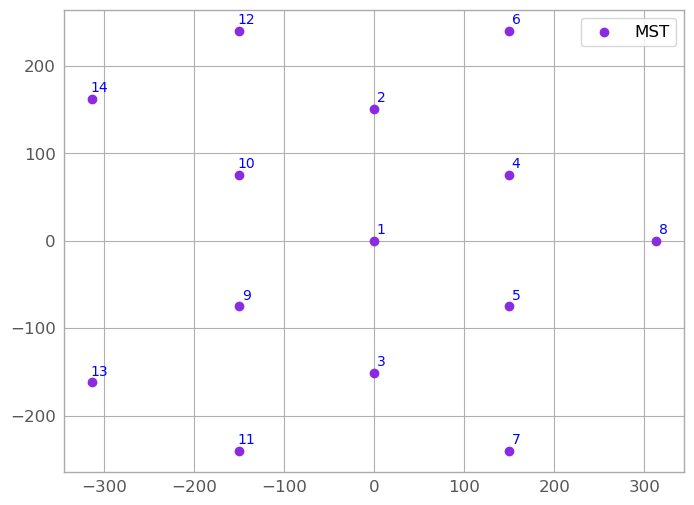

In [7]:
# Loop through all the telescopes
#for fov in array.table["fov"]:
#    print(fov)
colors = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in only_MST_array.table["fov"]
]
fov_labels = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}
for i in range(len(only_MST_array.table)):
    plt.scatter(only_MST_array.table['x'][i], only_MST_array.table['y'][i], c=colors[i], label=fov_labels[colors[i]])

    # Annotate each point with the telescope ID
    #matplotlib.pyplot.annotate(text, xy, xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None, **kwargs)
#Annotate the point xy with text text.
#In the simplest form, the text is placed at xy.
    plt.annotate(str(only_MST_array.table["id"][i]),
                 (only_MST_array.table['x'][i], only_MST_array.table['y'][i]),  # Point position
                 textcoords="offset points",  # Text position relative to the point
                 xytext=(5, 5),  # Offset in pixels (to avoid overlapping the point)
                 ha='center', fontsize=10, color='blue')
handles, labels = plt.gca().get_legend_handles_labels()
#handles, labels like this is doing
    #plt.gca() gets the current Axes object, which is where your plot is
    #.get_legend_handles_labels()
        #handles: Returns a list of the graphical elements (e.g., lines, scatter plot points) that would appear in the legend.
        # labels: Returns the text labels associated with each graphical element in handles

by_label = dict(zip(labels, handles))  # Remove duplicate labels, the dictionary by the structure takes out the double 
plt.legend(by_label.values(), by_label.keys())
#by_label.values This is pulling out the unique graphical elements
# by_label.keys  This is retrieving the unique text 
plt.savefig("./different_telescopes.png", dpi=300, bbox_inches="tight")
plt.show() 

In [8]:
sub_groups = {'1':[3,4,7], 
            '2': [1,9,12,14],
            '3': [10,11,13], 
            '4': [2,6,8,5]}


{'Group 2': <matplotlib.collections.PathCollection object at 0x12c94a360>, 'Group 4': <matplotlib.collections.PathCollection object at 0x12c94bda0>, 'Group 1': <matplotlib.collections.PathCollection object at 0x12c486b10>, 'Group 3': <matplotlib.collections.PathCollection object at 0x12c949c10>}


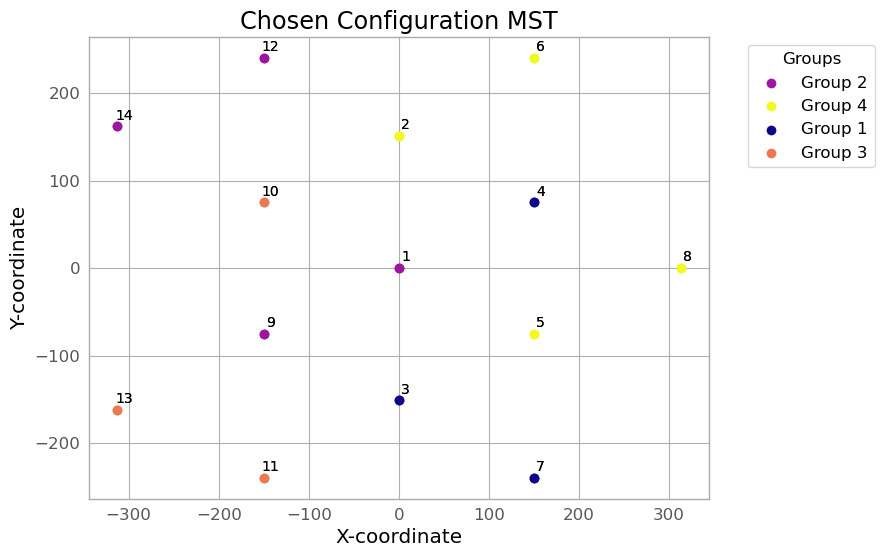

In [21]:
# Define colors for each subgroup
n_groups = len(sub_groups)
cmap = plt.cm.plasma

# Evenly spaced values between 0 and 1 for each group:
sub_group_colors = {
    str(i): cmap((i - 1) / (n_groups - 1)) for i in range(1, n_groups + 1)
}

# Create a dictionary mapping telescope IDs to their subgroup
id_to_subgroup = {}
for group, ids in sub_groups.items():
    for telescope_id in ids:
        id_to_subgroup[telescope_id] = group

# Assign a color to each telescope based on its subgroup
colors = [
    sub_group_colors.get(
        id_to_subgroup.get(telescope_id, '1'),  # Default subgroup to '1' if not found
        plt.cm.tab20(0)  # Default color (first color in tab20 colormap)
    )
    for telescope_id in only_SST_array.table["id"]
]

# Scatter plot for all points
for i in range(len(only_SST_array.table)):
    plt.scatter(
        only_SST_array.table['x'][i], 
        only_SST_array.table['y'][i], 
        c=[colors[i]],  # Wrap color in a list for scatter
        label=f"Group {id_to_subgroup.get(only_SST_array.table['id'][i], '1')}"
    )
    # Annotate each point with the telescope ID
    plt.annotate(
        str(only_SST_array.table["id"][i]),
        (only_SST_array.table['x'][i], only_SST_array.table['y'][i]),  # Point position
        textcoords="offset points",  # Text position relative to the point
        xytext=(5, 5),  # Offset in pixels
        ha='center', fontsize=10, color='black'
    )

# Add a legend for the subgroups (remove duplicates)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
print(by_label)
plt.legend(by_label.values(), by_label.keys(), title="Groups", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title("Chosen Configuration MST")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

{'Group 2': <matplotlib.collections.PathCollection object at 0x12c9bc110>, 'Group 4': <matplotlib.collections.PathCollection object at 0x12caaa1e0>, 'Group 1': <matplotlib.collections.PathCollection object at 0x12caa9be0>, 'Group 3': <matplotlib.collections.PathCollection object at 0x12c37c5c0>}


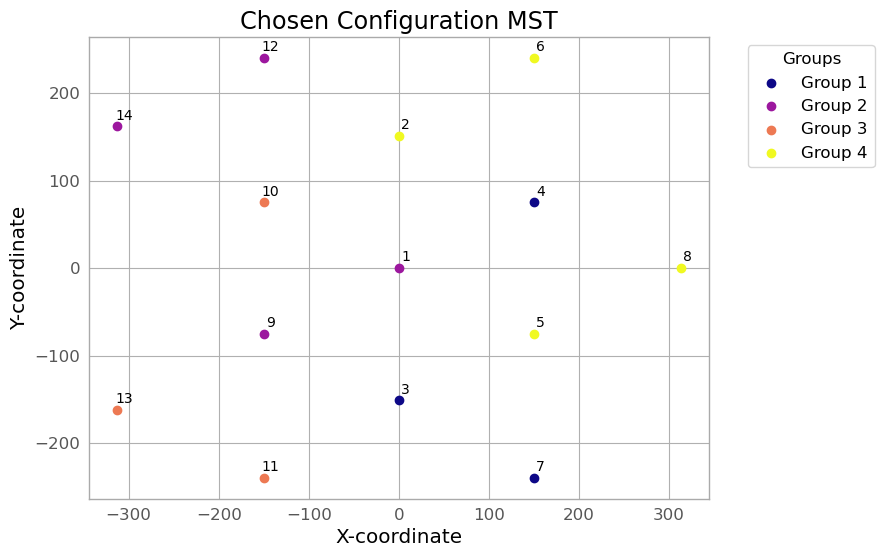

In [24]:
n_groups = len(sub_groups)
cmap = plt.cm.plasma

# Evenly spaced values between 0 and 1 for each group:
sub_group_colors = {
    str(i): cmap((i - 1) / (n_groups - 1)) for i in range(1, n_groups + 1)
}

# Create a dictionary mapping telescope IDs to their subgroup
id_to_subgroup = {}
for group, ids in sub_groups.items():
    for telescope_id in ids:
        id_to_subgroup[telescope_id] = group

# Assign a color to each telescope based on its subgroup
colors = [
    sub_group_colors.get(
        id_to_subgroup.get(telescope_id, '1'),  # Default subgroup to '1' if not found
        plt.cm.tab20(0)  # Default color (first color in tab20 colormap)
    )
    for telescope_id in only_SST_array.table["id"]
]

# Scatter plot for all points
for i in range(len(only_SST_array.table)):
    plt.scatter(
        only_SST_array.table['x'][i], 
        only_SST_array.table['y'][i], 
        c=[colors[i]],  # Wrap color in a list for scatter
        label=f"Group {id_to_subgroup.get(only_SST_array.table['id'][i], '1')}"
    )
    # Annotate each point with the telescope ID
    plt.annotate(
        str(only_SST_array.table["id"][i]),
        (only_SST_array.table['x'][i], only_SST_array.table['y'][i]),  # Point position
        textcoords="offset points",  # Text position relative to the point
        xytext=(5, 5),  # Offset in pixels
        ha='center', fontsize=10, color='black'
    )

# Add a legend for the subgroups (remove duplicates)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
print(by_label)
by_label=dict(sorted(by_label.items()))
plt.legend(by_label.values(), by_label.keys(), title="Groups", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title("Chosen Configuration MST")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()
